In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%load_ext autoreload
%autoreload 2
import copy
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from learning_wavelets.data.datasets import im_dataset_bsd68
from learning_wavelets.models.learnlet_model import Learnlet
from learning_wavelets.models.unet import unet
from learning_wavelets.utils.metrics import metrics_from_ds, metrics_original_from_ds


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.4.1     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 3.2.3     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [4]:
np.random.seed(0)

In [5]:
def build_learnlet_subclassing(**run_params):
    model = Learnlet(**run_params)
    model.build([[None, None, None, 1], [None, 1]])
    return model

In [6]:
def unet_base_params(run_id, name):
    base_params = {
        'name': name,
        'init_function': unet,
        'run_params': {
            'n_layers': 5, 
            'pool': 'max', 
            "layers_n_channels": [64, 128, 256, 512, 1024], 
            'layers_n_non_lins': 2,
            'non_relu_contract': False,
            'bn': True,
            'input_size': (None, None, 1),
        },
        'run_id': run_id,
        'epoch': 500,
    }
    return base_params

unet_run_ids_names = [
    ('unet_dynamic_st_bsd500_0_55_1576668365', 'unet_0_55'), 
    ('unet_dynamic_st_bsd500_20.0_40.0_1581002329', 'unet_20_40'),
    ('unet_dynamic_st_bsd500_30.0_30.0_1581002329', 'unet_30'),
]

all_net_params = [
    unet_base_params(run_id, name) for run_id, name in unet_run_ids_names
]
    
def learnlet_base_params(run_id, name):
    base_params = {
        'name': name,
        'init_function': build_learnlet_subclassing,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 64, 
                'mixing_details': False,    
                'skip_connection': True,
                'kernel_size': 11,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'threshold_kwargs':{
                'noise_std_norm': True,
            },
            'n_scales': 5,
            'exact_reconstruction': True,
            'n_reweights_learn': 1,
            'undecimated': True,
            'clip': False,
        },
        'run_id': run_id,
        'epoch': 500,
    }
    return base_params

learnlet_run_ids_names = [
    ('learnlet_subclassed_undecimated_64_dynamic_soft_thresholding_bsd500_0.0_55.0_None_1582736369', 'learnlet_0_55'),
    ('learnlet_subclassed_undecimated_64_dynamic_soft_thresholding_bsd500_0.0_55.0_None_1582736369', 'learnlet_20_40'),
    ('learnlet_subclassed_undecimated_64_dynamic_soft_thresholding_bsd500_0.0_55.0_None_1582736369', 'learnlet_30'),
]

dynamic_denoising_net_params = [
    learnlet_base_params(run_id, name) for run_id, name in learnlet_run_ids_names
]

In [7]:
noise_stds = [0.0001, 5, 15, 20, 25, 30, 50, 55, 60, 75]

In [8]:
noise_std_metrics = {}
n_samples = 2
for noise_std in tqdm_notebook(noise_stds, 'Noise stds'):
    metrics = []
    for net_params in all_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=False,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))
    im_ds = im_dataset_bsd68(
        mode='testing', 
        batch_size=1, 
        patch_size=None, 
        noise_std=noise_std, 
        return_noise_level=False,
        n_pooling=5,
        n_samples=n_samples,
    )
    metrics.append(('original', metrics_original_from_ds(im_ds)))
        
    for net_params in dynamic_denoising_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=True,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))

    noise_std_metrics[noise_std] = metrics

/volatile/home/Zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=1)
/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:43: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt, pred, multichannel=True, data_range=1


In [9]:
# PSNR table
psnr_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    psnr_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        psnr_metrics_table.loc[i, name] = "{mean:.4} ({std:.2})".format(
            mean=m.metrics['PSNR'].mean(), 
            std=m.metrics['PSNR'].stddev(),
        )
psnr_metrics_table;

In [10]:
# SSIM table
ssim_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    ssim_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        ssim_metrics_table.loc[i, name] = "{mean:.4} ({std:.4})".format(
            mean=m.metrics['SSIM'].mean(), 
            std=m.metrics['SSIM'].stddev(),
        )
ssim_metrics_table;

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
sns.set(style="whitegrid", palette="muted", rc={'figure.figsize': (9, 5), 'image.cmap': 'gray'})

In [13]:
relative_to_original = True

model_family_str = r'$\bf{Model}$'
train_stds_str = r'$\bf{Train}$  $\bf{std}$'
noise_std_str = r'$\sigma$'
psnr_str = 'Ratio over original PSNR'
# PSNR to plot
psnr_to_plot = pd.DataFrame(
    columns=[noise_std_str, psnr_str, 'psnr-std-dev', 'model_name', model_family_str, train_stds_str]
)

def from_name_to_family(model_name):
    if 'learnlet' in model_name:
        return 'Learnlets'
    elif 'unet' in model_name:
        return 'U-net'
    else:
        return 'Original'
    
def from_name_to_train_stds(model_name):
    if '30' in model_name:
        return '30'
    elif '20_40' in model_name:
        return '[20; 40]'
    else:
        return '[0; 55]'

family_model_to_color = {
    'U-net': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
    'Learnlets': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
    'Original': (0.41568627450980394, 0.8, 0.39215686274509803),
}
index = 0
orig_psnrs = {}
for i_noise, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    for j_model, (name, m) in enumerate(metrics):
        if relative_to_original and name == 'original':
            orig_psnrs[noise_std] = m.metrics['PSNR'].mean()
        else:
            psnr_to_plot.loc[index, noise_std_str] = noise_std
            psnr_to_plot.loc[index, psnr_str] = m.metrics['PSNR'].mean()
            psnr_to_plot.loc[index, 'psnr-std-dev'] = m.metrics['PSNR'].stddev() / 2
            psnr_to_plot.loc[index, 'model_name'] = name
            psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
            psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
            index += 1
    

if relative_to_original:
    for noise_std, orig_psnr in orig_psnrs.items():
        psnr_to_plot.loc[psnr_to_plot[noise_std_str] == noise_std, psnr_str] = psnr_to_plot[psnr_to_plot[noise_std_str] == noise_std][psnr_str] / orig_psnr
    
psnr_to_plot;

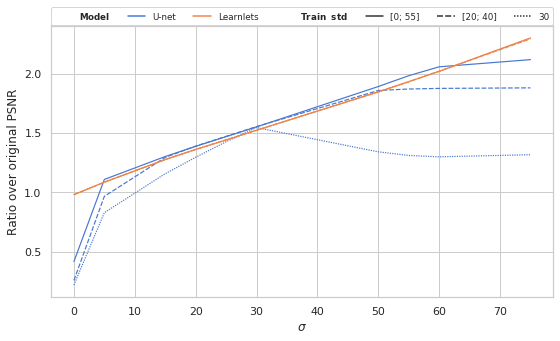

In [14]:
plt.figure(figsize=(9, 5))
psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
lplot = sns.lineplot(
    x=noise_std_str, 
    y=psnr_str, 
    hue=model_family_str,
    style=train_stds_str,
    data=psnr_to_plot,
    palette=family_model_to_color,
    linewidth=1.2,
)
plt.legend(bbox_to_anchor=(0., 1.01, 1., .05), loc='center', borderaxespad=0., ncol=7, fontsize=8.73)
plt.savefig(f'gen_wo_error_bars_train_noise_std.png')